### Context

We try to pose a small problem to have a better understanding about the paper "A Data Efficient Framework for Learning Local Heuristics" by Rishi Veerapaneni, Jonathan Park, Muhammad Suhail Saleem and Maxim Likhachev.

We implement the direct calculation of the local heuristic $h_k$ in orden to run $A^*$ with cost function $f(s) = g(s) + h_k(s) + h_g(s)$, where $g(s)$ is the real cost accumulated to node $s$ and $h_g(s)$ is defined as the euclidean distance from node $s$ to the goal, to find and optimal path beetween two points of a graph (this procedure will be described below); and we compare the results with classic $A^*$ with cost function $f(s) = g(s) + h_g(s)$.

### Implementation

#### Libraries

In [2]:
import random
from math import sqrt
import networkx as nx # representation of the graph and its visualization
import matplotlib.pyplot as plt # visualization
import heapq # implementation of A*
from collections import defaultdict

#### Utility functions

In [16]:
def draw_graph(G, colors=None, expanded_nodes=None):
  f, axs = plt.subplots(1, 1, figsize=(25, 25))
  pos = nx.spring_layout(G, seed=15) 

  if expanded_nodes is not None:
    expanded_nodes_set = set(expanded_nodes)
    non_expanded_nodes = list(set(G.nodes()) - expanded_nodes_set)

    nx.draw_networkx_nodes(G, pos, nodelist=non_expanded_nodes, node_size=300)
    nx.draw_networkx_nodes(G, pos, nodelist=list(expanded_nodes_set), node_size=300, node_color='orange')
  else:
    nx.draw_networkx_nodes(G, pos, node_size=300)

  nx.draw_networkx_edges(G, pos, edgelist=G.edges(data=True), width=2, edge_color=colors if colors else 'black')

  nx.draw_networkx_labels(G, pos, font_size=6, font_family="sans-serif", font_weight='bold')

  edge_labels = nx.get_edge_attributes(G, "weight")
  nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)
  plt.show()

In [14]:
def reconstruct_path(came_from, current):
  path = [current]
  while current in came_from:
    current = came_from[current]
    path.append(current)
  path.reverse()
  return path

In [15]:
def path_cost(G, path):
  return sum(G.edges[edge]['weight'] for edge in zip(path[:-1], path[1:]))

We define `distance()` to return the difference of $x$ and $y$ coordinates beetween two points, this metric is used to define $\text{LR}$ and $\text{LRB}$ in a way that $s'\in \text{LR}(s)$ if $|s'.x - s.x| \leq K$ and $|s'.y - s.y| \leq K$.

In [7]:
def distance(node1, node2):
  return abs(node1[0] - node2[0]), abs(node1[1] - node2[1])

def euclidean_distance(node1, node2):
  return sqrt((node1[0] - node2[0])**2 + (node1[1] - node2[1])**2)

Get nodes in the border of `s` based on `distance()`:

In [8]:
def get_local_region_border(G, s, K):
  border_nodes = []
  for node in G.nodes():
    distx, disty = distance(s, node)
    if (distx == K and disty <= K) or (disty == K and distx <= K):
      border_nodes.append(node)
  return border_nodes

#### Algorithms 

Here, we define the described local $A^*$ that finds the node in the border of $s$ with optimal cost:

In [9]:
def local_a_star(G, start, border_nodes):
  min_cost = float('inf')
  best_border_node = None

  for border_node in border_nodes:
    path = nx.astar_path(G, start, border_node, heuristic=euclidean_distance, weight='weight') 
    cost = sum(G.edges[edge]['weight'] for edge in zip(path[:-1], path[1:])) 
    if cost < min_cost:
      min_cost = cost
      best_border_node = border_node

  return min_cost, best_border_node

Here we implement $A^*$ with the local heuristic, for this we explicitely calculate $h_k$, we know this is the naive approach. 

In [11]:
def a_star_with_local_heuristic(G, start, goal, K):
  open_set = []
  heapq.heappush(open_set, (0, start))

  g_scores = defaultdict(lambda: float('inf'))
  g_scores[start] = 0

  came_from = {}
  expanded_nodes = []  

  while open_set:
    _, current = heapq.heappop(open_set)
    expanded_nodes.append(current)  

    # If we get to the goal, reconstruct the path
    if current == goal:
      return reconstruct_path(came_from, current), expanded_nodes

    # Get LRB of current node
    local_border = get_local_region_border(G, current, K)

    # Calculate local heuristic
    local_cost, _ = local_a_star(G, current, local_border)
    h_global = euclidean_distance(current, goal)
    h_local = local_cost - h_global

    # Expand
    for neighbor in G.neighbors(current):
      tentative_g_score = g_scores[current] + G.edges[current, neighbor]['weight']
      f_score = tentative_g_score + h_global + h_local
      # f_score = tentative_g_score + h_local # Is this also valid?

      if tentative_g_score < g_scores[neighbor]:
        came_from[neighbor] = current
        g_scores[neighbor] = tentative_g_score
        heapq.heappush(open_set, (f_score, neighbor))

  return None, expanded_nodes 

Here we implement the classic $A^*$ with heuristic $h_g$.

In [13]:
def a_star_classic(G, start, goal):
  open_set = []
  heapq.heappush(open_set, (0, start))

  g_scores = defaultdict(lambda: float('inf'))
  g_scores[start] = 0

  came_from = {}
  expanded_nodes = []  

  while open_set:
    _, current = heapq.heappop(open_set)
    expanded_nodes.append(current)  

    if current == goal:
      return reconstruct_path(came_from, current), expanded_nodes

    for neighbor in G.neighbors(current):
      tentative_g_score = g_scores[current] + G.edges[current, neighbor]['weight']
      h_global = euclidean_distance(neighbor, goal)
      f_score = tentative_g_score + h_global

      if tentative_g_score < g_scores[neighbor]:
        came_from[neighbor] = current
        g_scores[neighbor] = tentative_g_score
        heapq.heappush(open_set, (f_score, neighbor))

  return None, expanded_nodes

### Example

Consider the graph $G = (V, E, W)$, defined in the following way:

In [20]:
G = nx.grid_2d_graph(10, 10)  # (10x10)-Grid
pos = {n: n for n in G.nodes()}  # (x, y) positions of the nodes
random.seed(5)
for edge in G.edges():
    G.edges[edge]['weight'] = sqrt((edge[0][0] - edge[1][0]) ** 2 + (edge[0][1] - edge[1][1]) ** 2) + random.randint(0, 8)

Uncomment to get different results:

In [21]:
# high_cost_edges = [((2, 3), (2, 4)), ((5, 5), (6, 5)), ((8, 1), (8, 2)), ((3, 7), (4, 7)), ((4, 8), (5, 8)), ((4, 9), (5, 9))]
# for edge in high_cost_edges:
#     G.edges[edge]['weight'] += 15
# edges_to_remove = [((4, 2), (5, 2)), ((1, 6), (2, 6)), ((7, 8), (7, 9)), ((0, 4), (0, 5)), ((4, 6), (5, 6)), ((4, 7), (5, 7))]
# G.remove_edges_from(edges_to_remove)

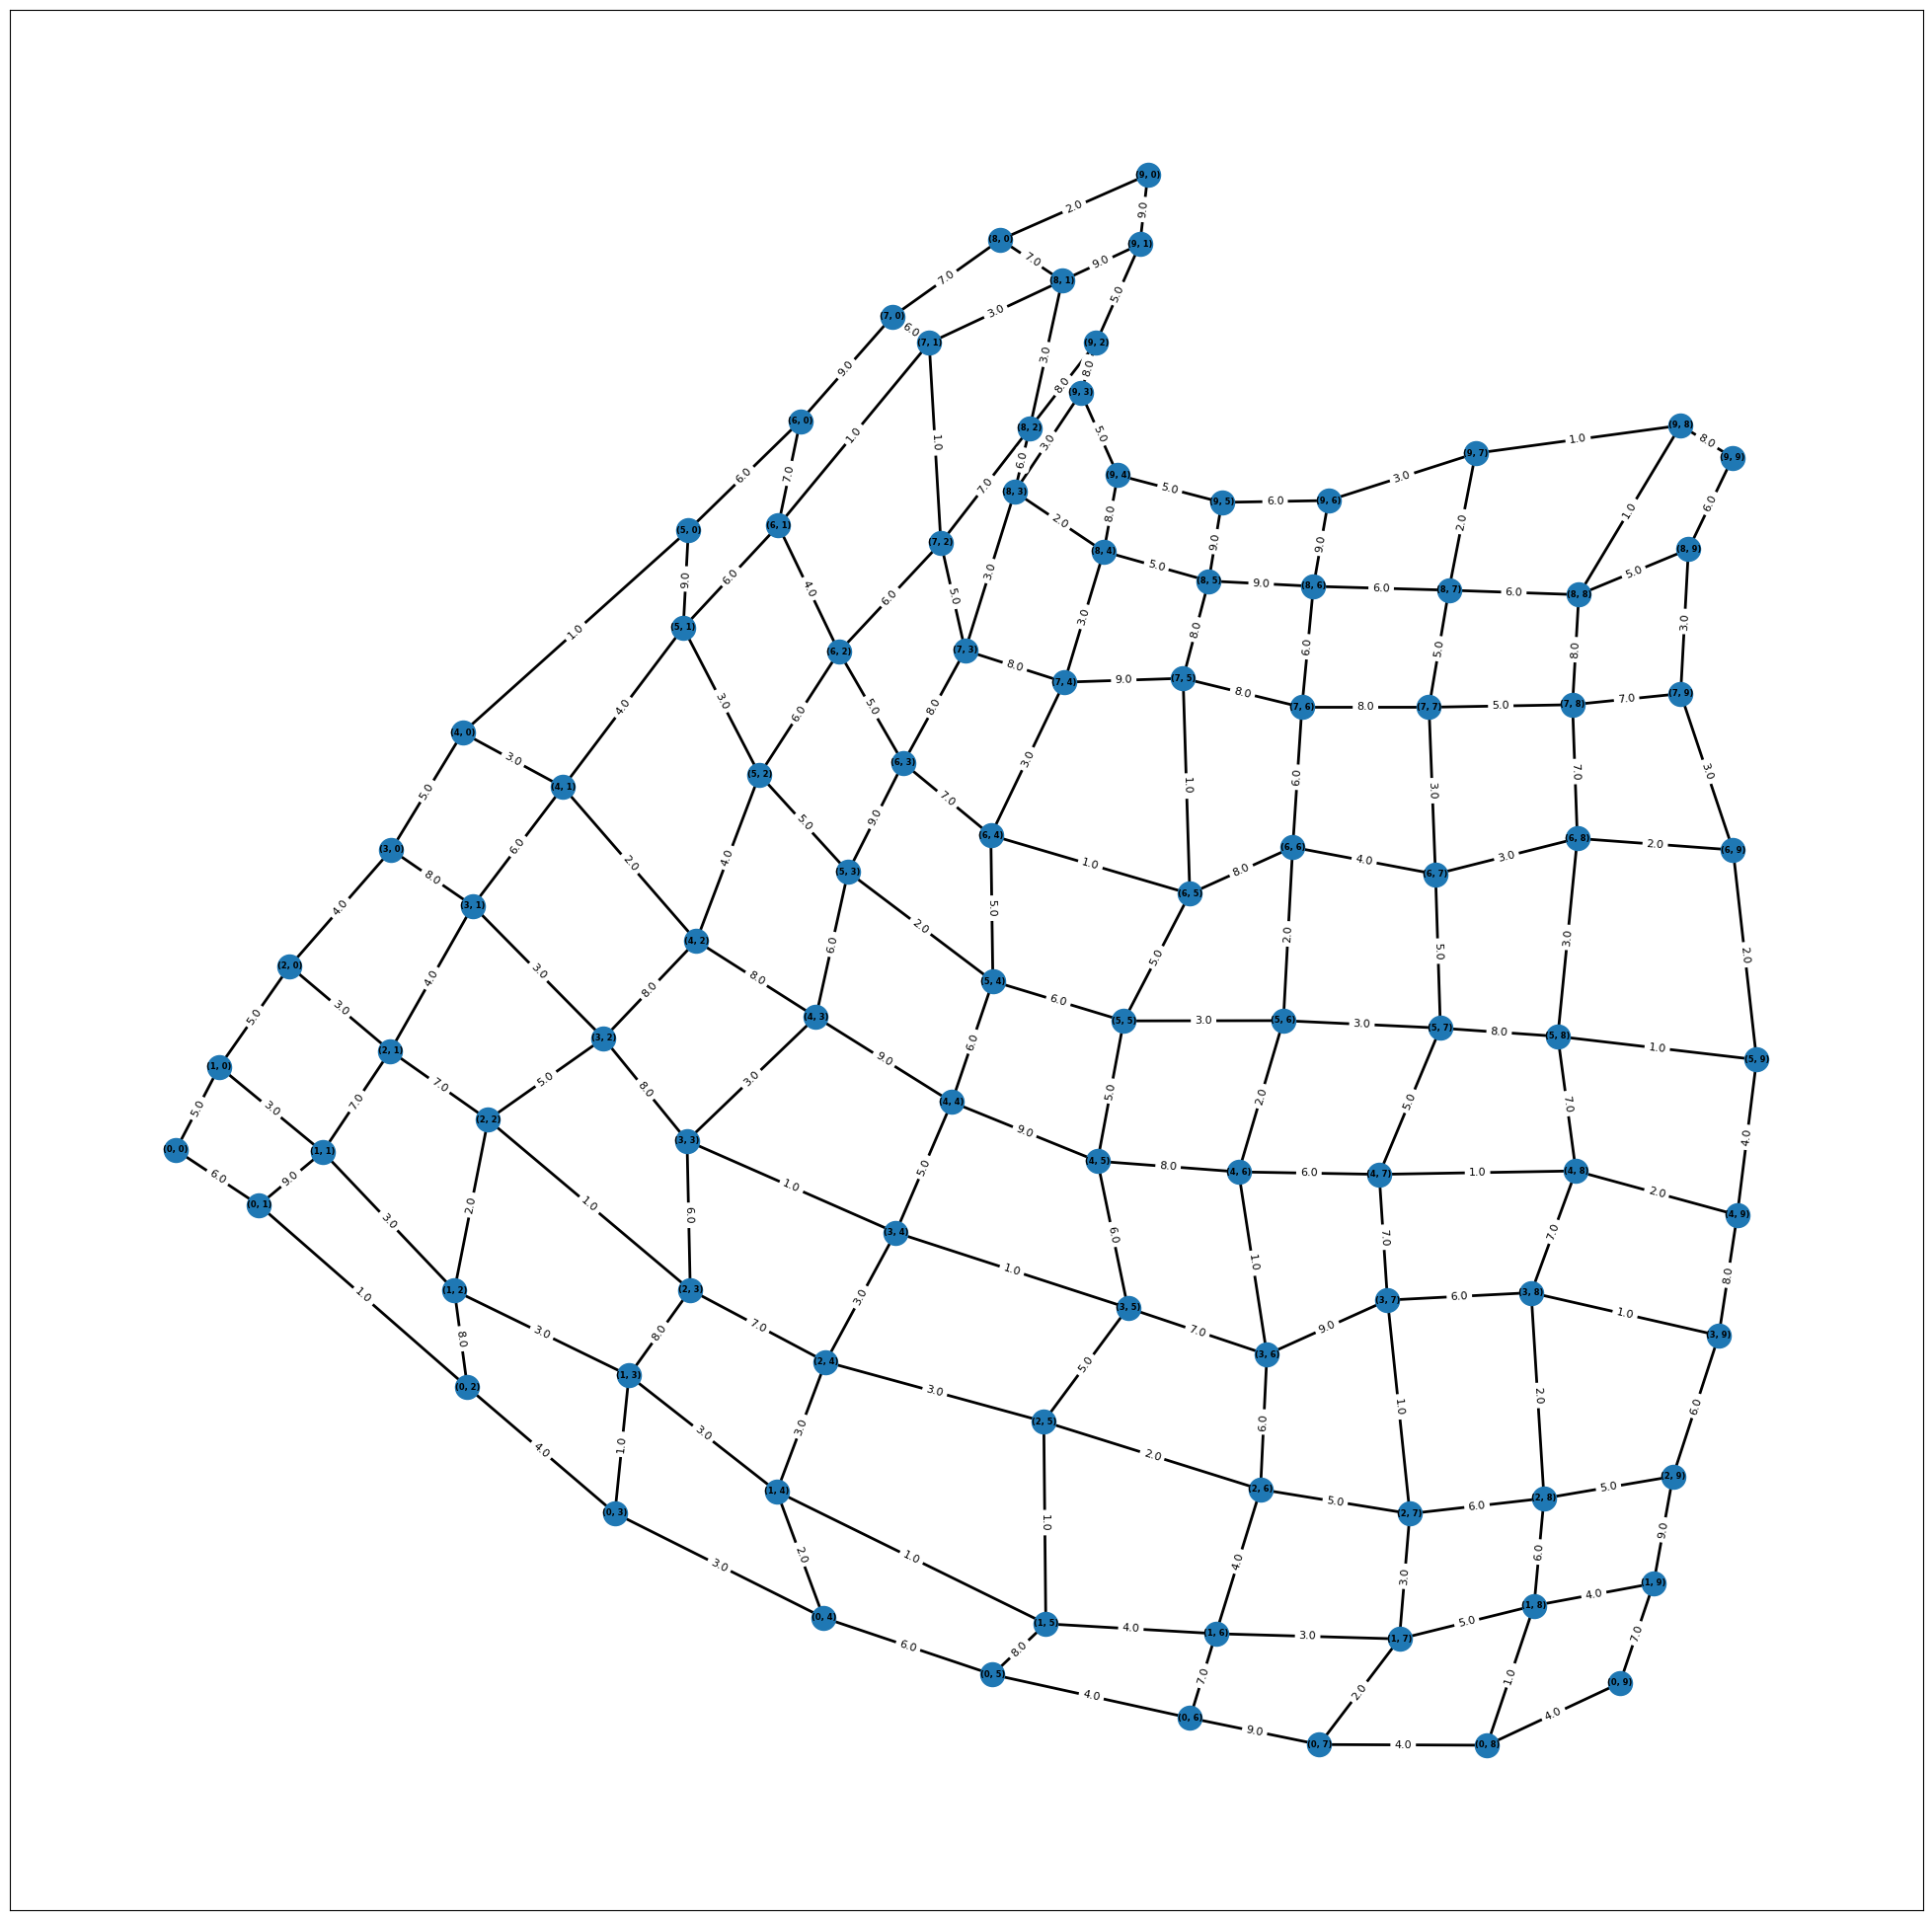

In [19]:
draw_graph(G)

We define $s_0=(0,0)$, $s_{goal}=(9,9)$ and $K=7$.

In [22]:
start = (0, 0)
goal = (9, 9)
K = 7

#### Results

- Expanded nodes are in color orange.
- Unexpanded nodes in color blue.
- Path found in color red.

##### A* with local heuristic

Path found from (0, 0) to (9, 9): [(0, 0), (0, 1), (0, 2), (0, 3), (1, 3), (1, 4), (1, 5), (2, 5), (2, 6), (2, 7), (3, 7), (4, 7), (4, 8), (4, 9), (5, 9), (6, 9), (7, 9), (8, 9), (9, 9)]
Number of expanded nodes (local A*): 100
Cost: 53.0


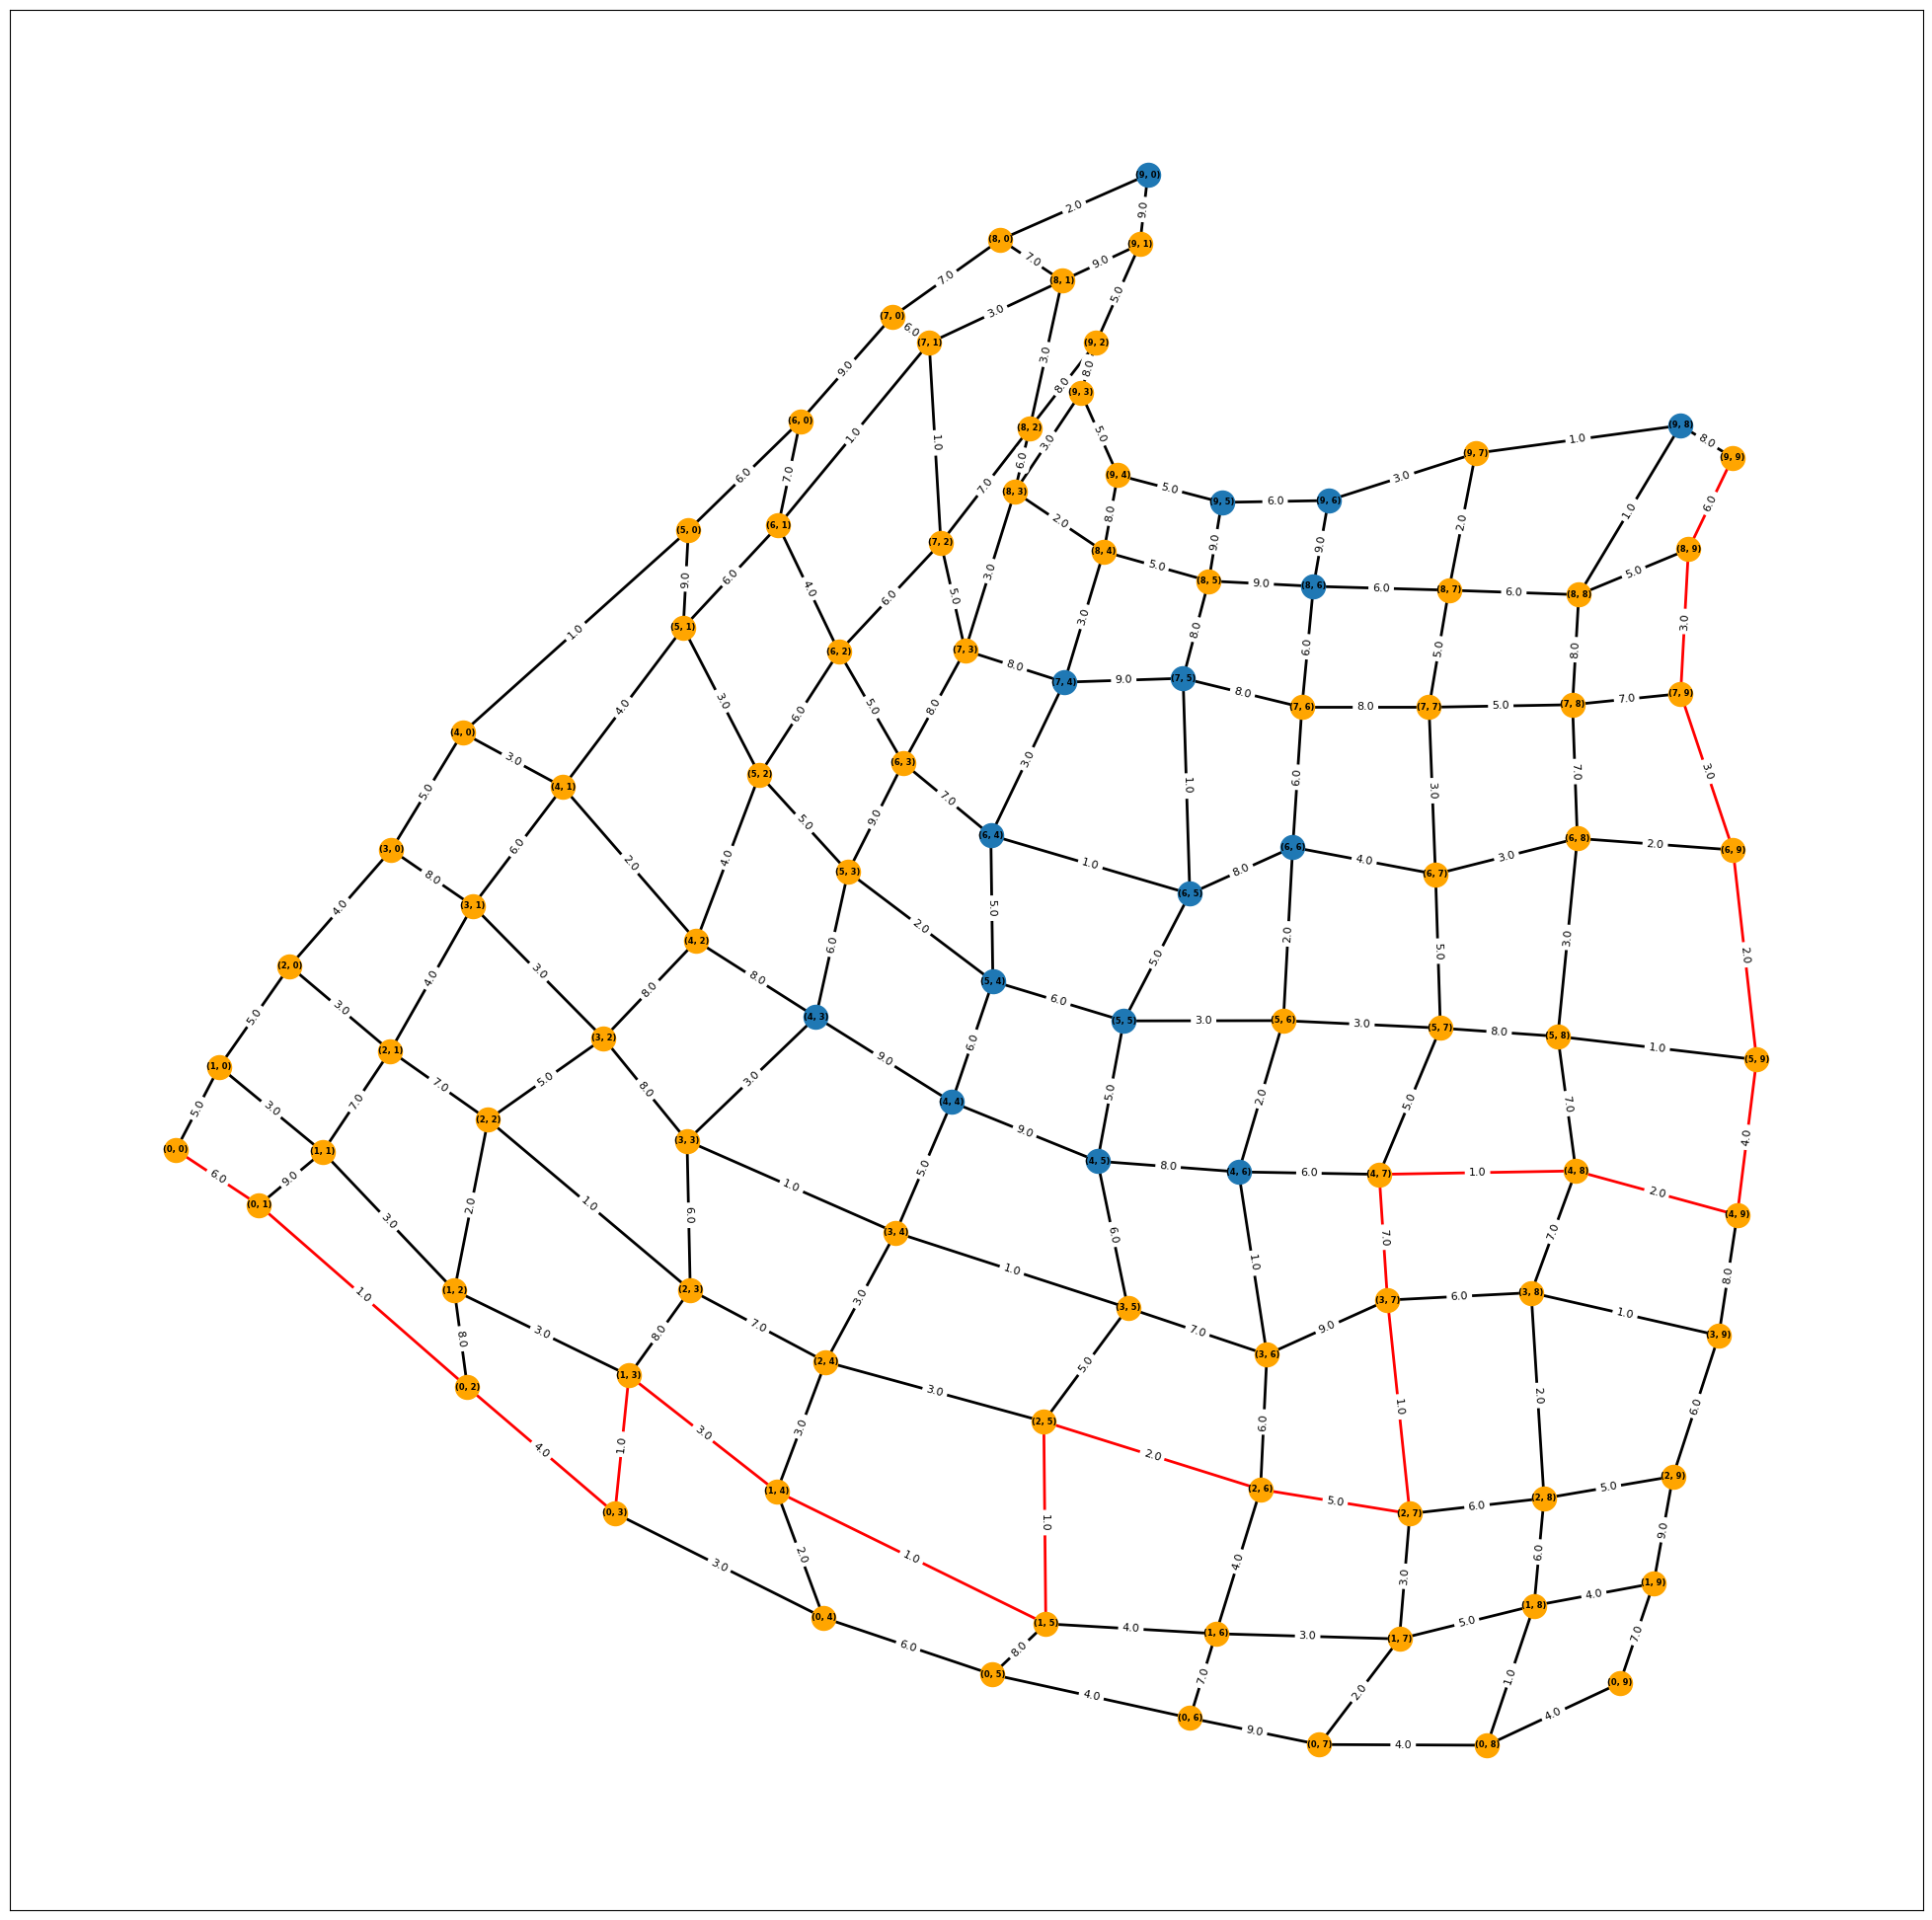

In [25]:
path_to_goal, expanded_nodes_local = a_star_with_local_heuristic(G, start, goal, K)
print(f"Path found from {start} to {goal}: {path_to_goal}")
print(f"Number of expanded nodes (local A*): {len(expanded_nodes_local)}")
costo = path_cost(G, path_to_goal)
print(f"Cost: {costo}")

edge_colors = [
  'red' if ((u, v) in zip(path_to_goal[:-1], path_to_goal[1:]) or 
            (v, u) in zip(path_to_goal[:-1], path_to_goal[1:]))
  else 'black'
  for u, v in G.edges()
]
draw_graph(G, colors=edge_colors, expanded_nodes=expanded_nodes_local)

##### A* with global heuristic

Path found from (0, 0) to (9, 9): [(0, 0), (0, 1), (0, 2), (0, 3), (1, 3), (1, 4), (1, 5), (2, 5), (2, 6), (3, 6), (4, 6), (5, 6), (6, 6), (6, 7), (6, 8), (6, 9), (7, 9), (8, 9), (9, 9)]
Number of expanded nodes (classic A*): 110
Cost: 51.0


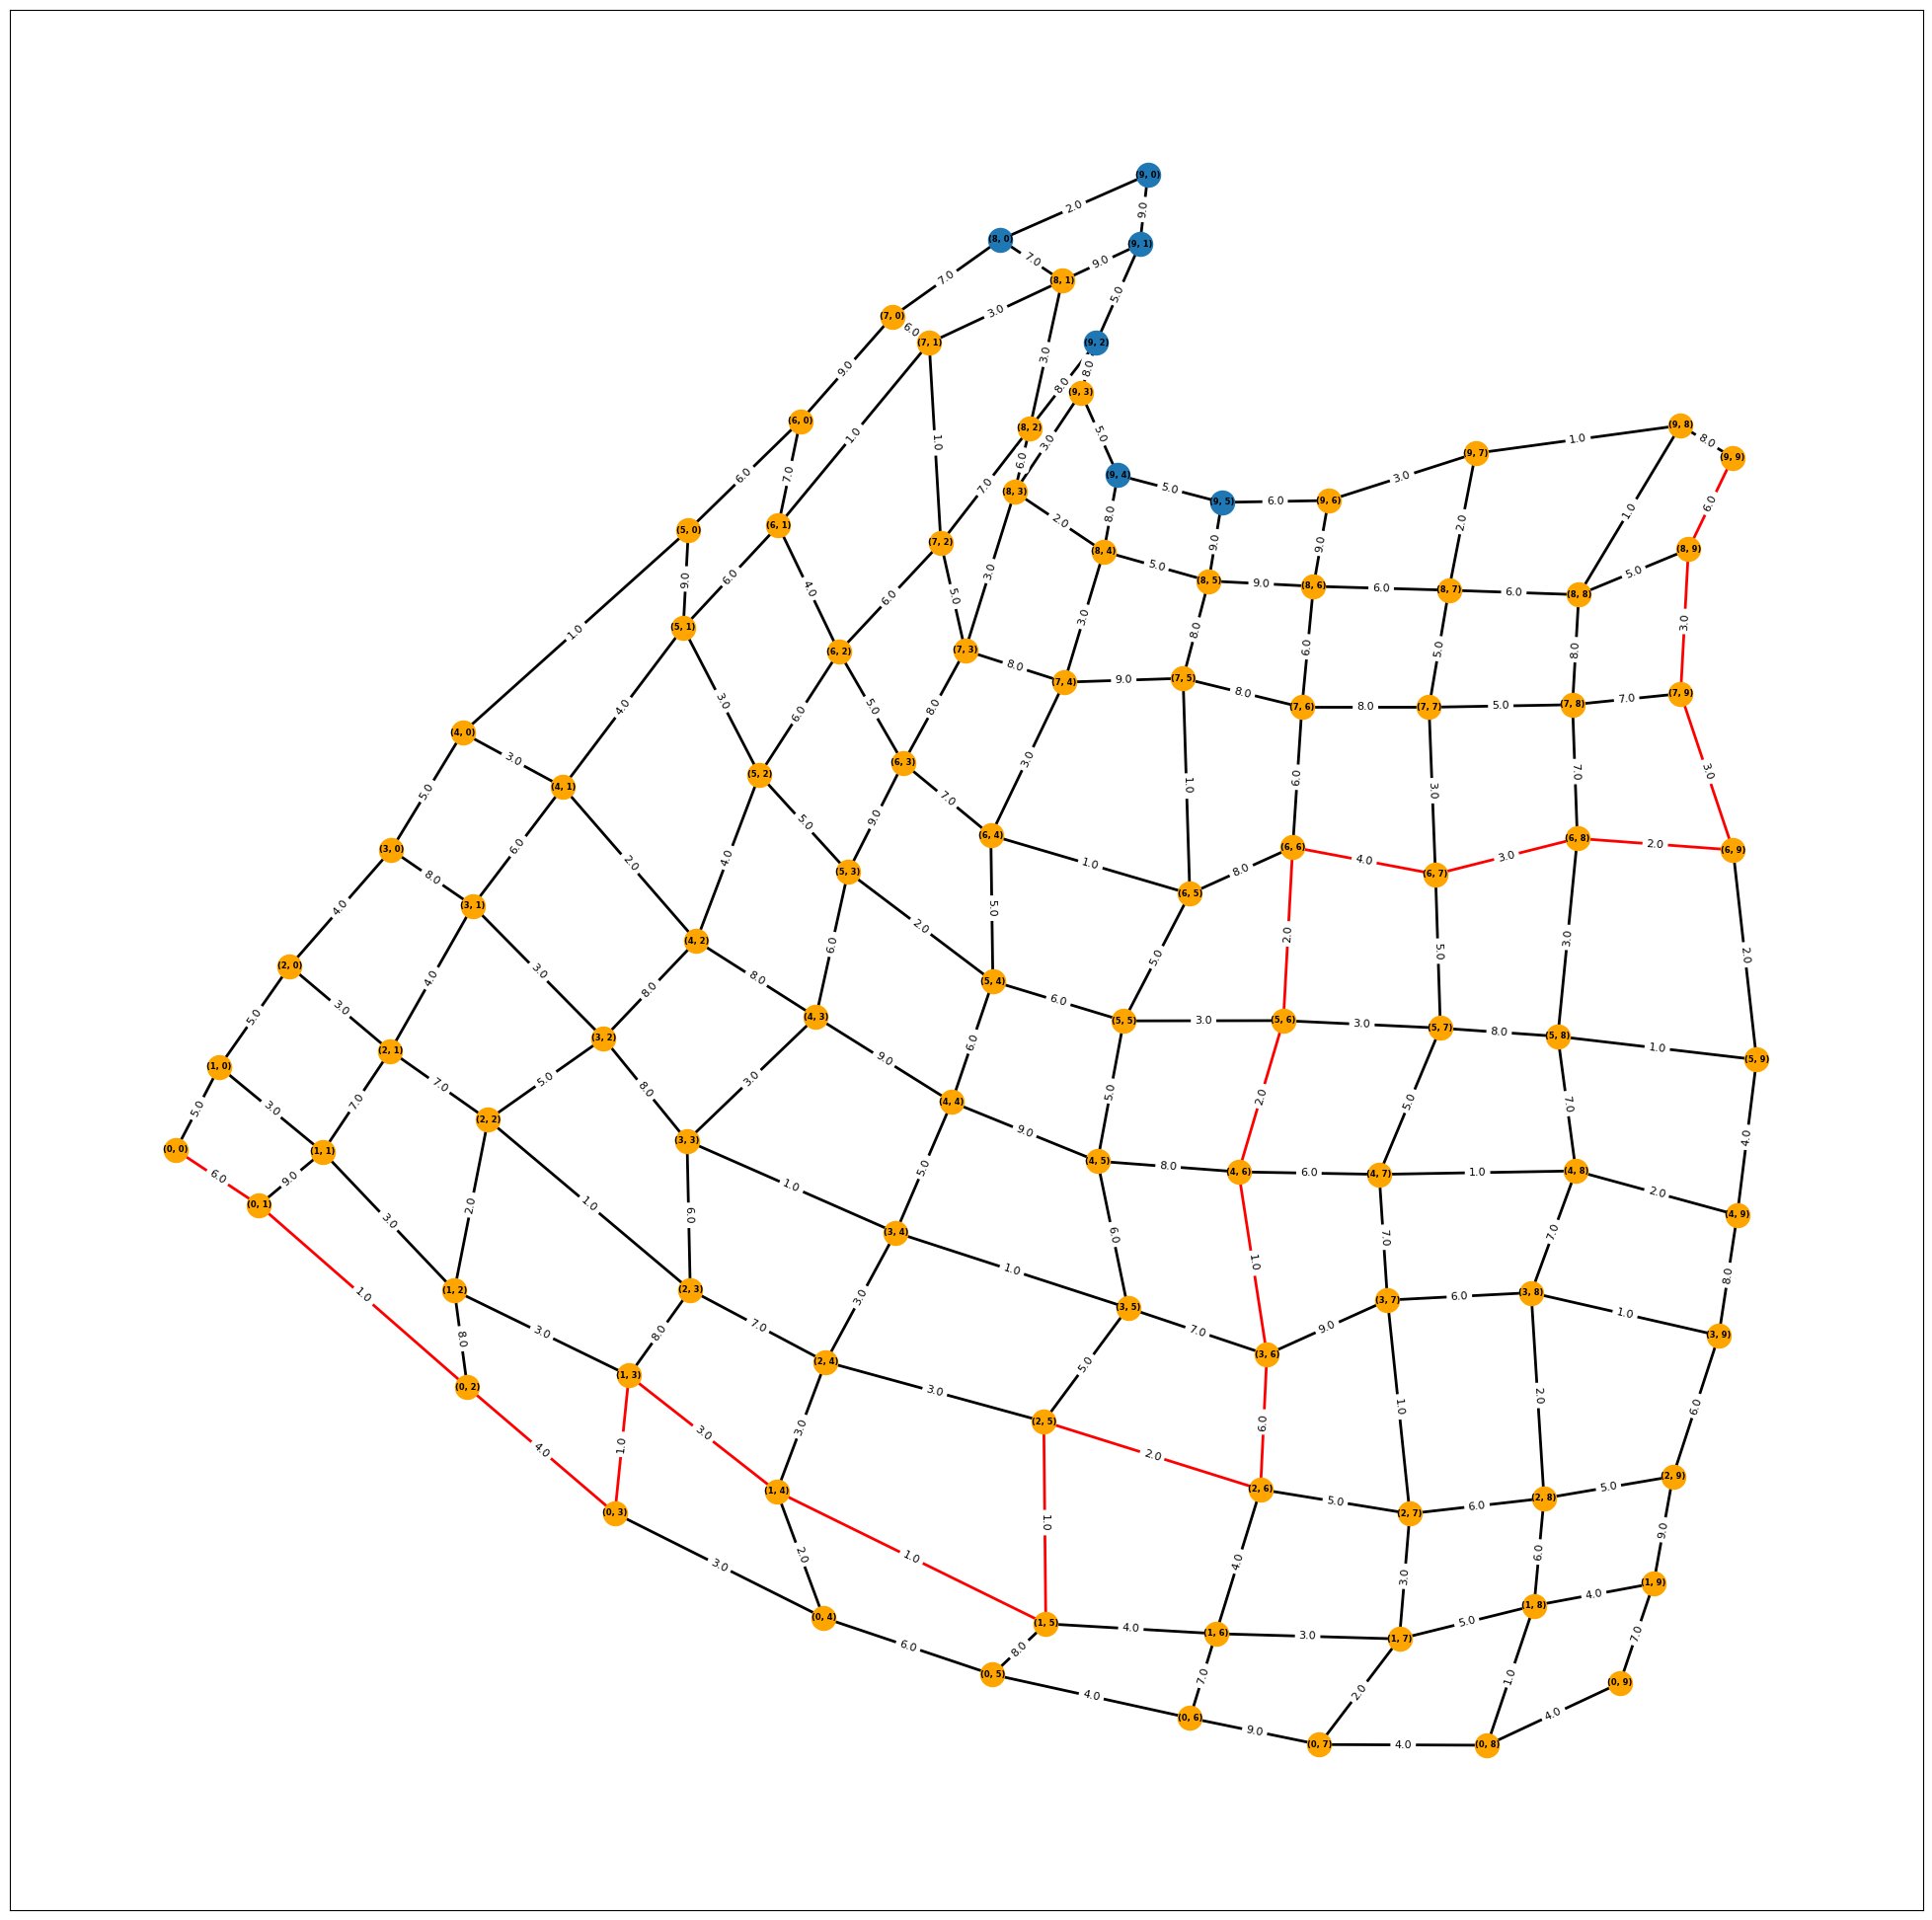

In [26]:
path_classic, expanded_nodes_classic = a_star_classic(G, start, goal)
print(f"Path found from {start} to {goal}: {path_classic}")
print(f"Number of expanded nodes (classic A*): {len(expanded_nodes_classic)}")
costo_classic = path_cost(G, path_classic)
print(f"Cost: {costo_classic}")

edge_colors_classic = [
  'red' if ((u, v) in zip(path_classic[:-1], path_classic[1:]) or 
            (v, u) in zip(path_classic[:-1], path_classic[1:]))
  else 'black'
  for u, v in G.edges()
]
draw_graph(G, colors=edge_colors_classic, expanded_nodes=expanded_nodes_classic)